# Construção da Classe

In [1]:
from statsmodels.tsa.ar_model import AutoReg
from tabulate import tabulate
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller, kpss
import pandas as pd
import warnings
# Ignorar todos os warnings
warnings.filterwarnings("ignore")


In [2]:
class GrangerScope:
    """
    Analyzes causal relationships between two time series using stationarity tests (ADF, KPSS), 
    Granger causality, and Vector Autoregression (VAR). Provides automated reporting and visualization.

    Attributes:
        df (pd.DataFrame): DataFrame with two columns 'x' and 'y' for analysis.
        max_lag (int): Maximum lag for the VAR and Granger tests.
        diff_level (int): Level of differentiation applied to achieve stationarity.
        _results (dict): Stores the outcomes of various tests, including Granger causality and model metrics.
        _stationarity_results (dict): Stores the initial results of stationarity tests (ADF, KPSS).
    """
    


    def __init__(self, df, max_lag):
        """
        Initializes the GrangerVARAnalyzer with a DataFrame and max lag, and runs the full analysis pipeline.
        
        Args:
            df (pd.DataFrame): DataFrame with two columns 'x' and 'y'.
            max_lag (int): Maximum number of lags to be considered in the analysis.
            
        Raises:
            ValueError: If max_lag exceeds 27% of the DataFrame's length or if 'x' and 'y' columns are not in df.
        """
        self.df = df
        self.max_lag = max_lag
        self.diff_level = 0
        self._results = {}
        self._stationarity_results = {}

        self.validate_lag()
        self.run_analysis()



    def validate_lag(self):
        """Verifies if max_lag is appropriate given the length of the data."""
        if 'x' not in self.df.columns or 'y' not in self.df.columns:
            raise ValueError("DataFrame must contain 'x' and 'y' columns.")
        if self.max_lag > 0.27 * len(self.df):
            raise ValueError("Erro: O lag máximo excede 27% do comprimento dos dados.")
    


    @staticmethod
    def adf_test(series):
        """Executes the ADF test and returns the p-value."""
        result = adfuller(series)
        return result[1]



    @staticmethod
    def kpss_test(series):
        """Executes the KPSS test and returns the p-value."""
        result = kpss(series, regression='c', nlags="auto")
        return result[1]



    def check_stationarity_and_diff(self):
        """
        Checks and enforces stationarity by applying differentiation as needed.
        
        Returns:
            pd.DataFrame: Differentiated series DataFrame.
            int: Number of differences applied.
        """
        # Initial stationarity tests
        adf_x, adf_y = self.adf_test(self.df['x']), self.adf_test(self.df['y'])
        kpss_x, kpss_y = self.kpss_test(self.df['x']), self.kpss_test(self.df['y'])
        x_non_stationary, y_non_stationary = adf_x > 0.05 or kpss_x < 0.05, adf_y > 0.05 or kpss_y < 0.05

        # Store initial stationarity results
        self._stationarity_results = {
            'x': {'ADF p-value': adf_x, 'KPSS p-value': kpss_x, 'Non-Stationary': x_non_stationary},
            'y': {'ADF p-value': adf_y, 'KPSS p-value': kpss_y, 'Non-Stationary': y_non_stationary}
        }

        # Differencing until stationarity
        diff_level = 0
        df_diff = self.df.copy()
        while x_non_stationary or y_non_stationary:
            df_diff = df_diff.diff().dropna()
            diff_level += 1
            x_non_stationary = self.adf_test(df_diff['x']) > 0.05 or self.kpss_test(df_diff['x']) < 0.05
            y_non_stationary = self.adf_test(df_diff['y']) > 0.05 or self.kpss_test(df_diff['y']) < 0.05

        self.diff_level = diff_level
        return df_diff, diff_level



    def granger_test(self, df_stationary):
        """
        Conducts Granger causality tests up to the specified maximum lag.
        
        Args:
            df_stationary (pd.DataFrame): Stationary version of the original data after differencing.

        Returns:
            dict: Dictionary with p-values for each test (F-test, Chi-square, Likelihood Ratio).
        """
        granger_results = {}
        
        for lag in range(1, self.max_lag + 1):
            test_result = grangercausalitytests(df_stationary[['y', 'x']], maxlag=lag, verbose=False)
            granger_results[lag] = {
                'p_value_f': test_result[lag][0]['ssr_ftest'][1],
                'p_value_chi2': test_result[lag][0]['ssr_chi2test'][1],
                'p_value_lr': test_result[lag][0]['lrtest'][1]
            }
        
        self._results['granger'] = granger_results
        return granger_results
    


    def fit_var_models(self, df_stationary):
        """
        Fits VAR models for lags up to max_lag and collects metrics (AIC, BIC, HQIC, FPE).
        
        Args:
            df_stationary (pd.DataFrame): Stationary version of the original data after differencing.

        Returns:
            dict: Dictionary with model metrics for both restricted and unrestricted models.
        """
        var_metrics = {'restricted': {}, 'unrestricted': {}}
        
        for lag in range(1, self.max_lag + 1):
            # Unrestricted VAR model with lags of x and y
            model_irrestrito = VAR(df_stationary).fit(lag)
            var_metrics['unrestricted'][lag] = {
                'AIC': model_irrestrito.aic,
                'BIC': model_irrestrito.bic,
                'HQIC': model_irrestrito.hqic,
                'FPE': model_irrestrito.fpe
            }
            
            # Restricted AR model with only lags of y
            y_series = df_stationary['y']
            model_restrito = AutoReg(y_series, lags=lag).fit()
            var_metrics['restricted'][lag] = {
                'AIC': model_restrito.aic,
                'BIC': model_restrito.bic,
                'HQIC': model_restrito.hqic,
                'FPE': model_restrito.sigma2
            }
        
        self._results['var_metrics'] = var_metrics
        return var_metrics
    

    
    def generate_report(self):
        """Generates a detailed report of stationarity tests, Granger causality, and model selection criteria."""
        
        print("RESULTADOS DA ANÁLISE DE GRANGER E LAG ÓTIMO")
        print(" ")
        
        # Stationarity test results
        print("Resultados dos Testes de Estacionaridade Iniciais (ADF e KPSS)")
        stationarity_data = [
            ["x", self._stationarity_results['x']['ADF p-value'], self._stationarity_results['x']['KPSS p-value'], 
             "Não Estacionária" if self._stationarity_results['x']['Non-Stationary'] else "Estacionária"],
            ["y", self._stationarity_results['y']['ADF p-value'], self._stationarity_results['y']['KPSS p-value'], 
             "Não Estacionária" if self._stationarity_results['y']['Non-Stationary'] else "Estacionária"]
        ]
        print(tabulate(stationarity_data, headers=["Série", "ADF p-valor", "KPSS p-valor", "Estacionaridade"]))
        
        # Differentiation level
        if self.diff_level > 0:
            print(f"\nNúmero de diferenciações aplicadas para tornar as séries estacionárias: {self.diff_level}")
        else:
            print("\nAs séries já eram estacionárias, sem necessidade de diferenciação.")
        
        # Granger test results
        granger_data = []
        for lag, res in self._results['granger'].items():
            if res['p_value_f'] < 0.05 or res['p_value_chi2'] < 0.05:
                granger_data.append([lag, res['p_value_f'], res['p_value_chi2']])
        if not granger_data:
            print("\nNenhum lag apresentou p-valor significativo no teste de Granger.")
        else:
            print("\nResultados do Teste de Granger (Lags Significativos)")
            print(tabulate(granger_data, headers=["Lag", "p-valor F", "p-valor Chi-Square"]))
        
        # Optimal lags based on criteria
        if granger_data:
            optimal_lags = {
                'AIC': min(granger_data, key=lambda x: self._results['var_metrics']['unrestricted'][x[0]]['AIC'])[0],
                'BIC': min(granger_data, key=lambda x: self._results['var_metrics']['unrestricted'][x[0]]['BIC'])[0],
                'HQIC': min(granger_data, key=lambda x: self._results['var_metrics']['unrestricted'][x[0]]['HQIC'])[0],
                'FPE': min(granger_data, key=lambda x: self._results['var_metrics']['unrestricted'][x[0]]['FPE'])[0]
            }
            adjusted_lags = {criterion: lag + self.diff_level for criterion, lag in optimal_lags.items()}
            report_data = [[criterion, optimal_lags[criterion], adjusted_lag] for criterion, adjusted_lag in adjusted_lags.items()]
            print("\nLags Ótimos Baseados em Critérios de Informação (Apenas Lags Significativos)")
            print(tabulate(report_data, headers=["Critério", "Lag Ótimo", "Lag Ajustado"]))




    def plot_results(self):
        """Plots p-values and model metrics for analysis."""
        # Plot of p-values for the Granger test
        lags = list(self._results['granger'].keys())
        p_values_f = [self._results['granger'][lag]['p_value_f'] for lag in lags]
        p_values_chi2 = [self._results['granger'][lag]['p_value_chi2'] for lag in lags]
        
        plt.figure(figsize=(10, 6))
        plt.plot(lags, p_values_f, label='p-valor F-test')
        plt.plot(lags, p_values_chi2, label='p-valor Chi-Square')
        plt.axhline(0.05, color='red', linestyle='--')
        plt.xlabel('Número de Lags')
        plt.ylabel('P-valor')
        plt.legend()
        plt.title('P-valores para Testes de Granger')
        plt.show()
        
        # Plot of model information criteria
        aic = [self._results['var_metrics']['unrestricted'][lag]['AIC'] for lag in lags]
        bic = [self._results['var_metrics']['unrestricted'][lag]['BIC'] for lag in lags]
        hqic = [self._results['var_metrics']['unrestricted'][lag]['HQIC'] for lag in lags]
        
        plt.figure(figsize=(10, 6))
        plt.plot(lags, aic, label='AIC')
        plt.plot(lags, bic, label='BIC')
        plt.plot(lags, hqic, label='HQIC')
        plt.xlabel('Número de Lags')
        plt.ylabel('Critério')
        plt.legend()
        plt.title('Critérios de Informação')
        plt.show()
        
        # Plot of FPE for restricted and unrestricted models
        fpe_restrito = [self._results['var_metrics']['restricted'][lag]['FPE'] for lag in lags]
        fpe_irrestrito = [self._results['var_metrics']['unrestricted'][lag]['FPE'] for lag in lags]
        
        plt.figure(figsize=(10, 6))
        plt.plot(lags, fpe_restrito, label='FPE Restrito')
        plt.plot(lags, fpe_irrestrito, label='FPE Irrestrito')
        plt.xlabel('Número de Lags')
        plt.ylabel('FPE')
        plt.legend()
        plt.title('FPE para Modelos Restritos e Irrestritos')
        plt.show()



    def run_analysis(self):
        """
        Executes the full analysis pipeline: stationarity tests, Granger causality, VAR model fitting,
        and generates plots and reports.
        """
        df_stationary, _ = self.check_stationarity_and_diff()
        self.granger_test(df_stationary)
        self.fit_var_models(df_stationary)
        self.generate_report()
        self.plot_results()



# Teste da Classe

RESULTADOS DA ANÁLISE DE GRANGER E LAG ÓTIMO
 
Resultados dos Testes de Estacionaridade Iniciais (ADF e KPSS)
Série      ADF p-valor    KPSS p-valor  Estacionaridade
-------  -------------  --------------  -----------------
x             0.374183            0.01  Não Estacionária
y             0.303492            0.01  Não Estacionária

Número de diferenciações aplicadas para tornar as séries estacionárias: 1

Resultados do Teste de Granger (Lags Significativos)
  Lag    p-valor F    p-valor Chi-Square
-----  -----------  --------------------
    1  0.0228984             0.0201647
    2  1.03577e-07           7.67136e-09
    3  7.00358e-09           9.29781e-11
    4  1.90265e-09           5.51498e-12
    5  1.81332e-10           4.60367e-14
    6  5.65998e-10           8.73216e-14
    7  3.8809e-10            1.24644e-14
    8  2.58107e-09           9.43499e-14
    9  8.86074e-09           2.37562e-13
   10  2.3129e-08            3.78793e-13

Lags Ótimos Baseados em Critérios de Infor

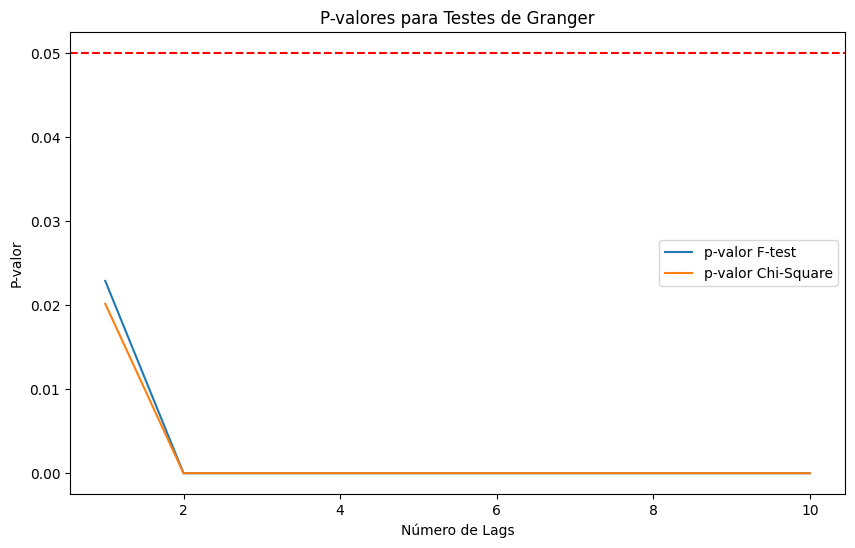

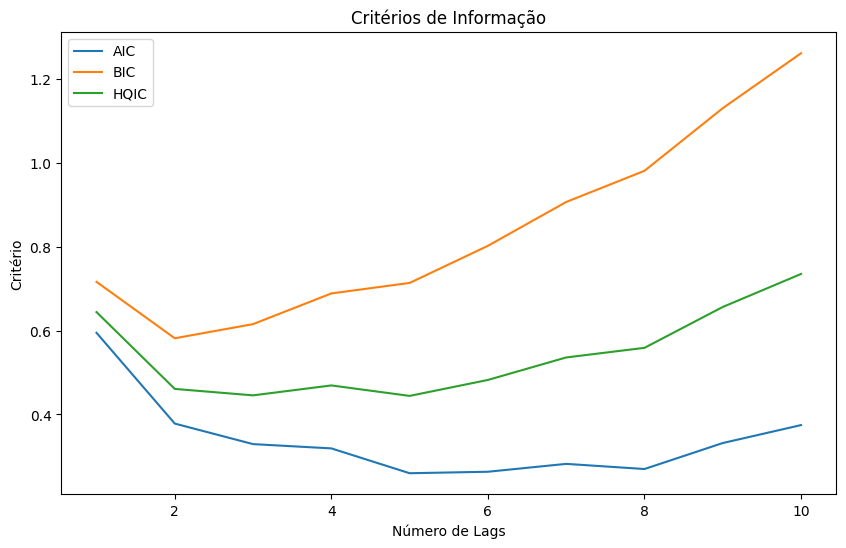

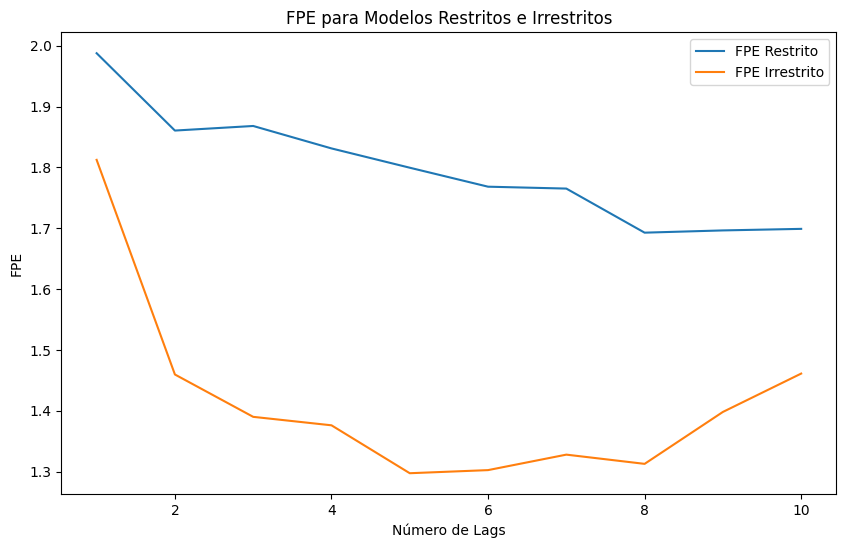

In [3]:
# Parâmetros
np.random.seed(42)
n = 150  # número de pontos da série
# Série X: uma sequência temporal com ruído
x = np.cumsum(np.random.normal(loc=0, scale=1, size=n))
# Série Y: depende dos valores passados de X mais um ruído adicional
y = [0] * n
for i in range(2, n):
    y[i] = 0.5 * x[i - 1] + 0.3 * x[i - 2] + np.random.normal(0, 1)
# Criação do DataFrame
df = pd.DataFrame({'x': x, 'y': y})
# Exibindo as primeiras linhas do DataFrame
#df = df.asfreq('D')  # Define a frequência como diária, ou 'M' para mensal, etc.
df.head()


# Instanciar e executar a análise com a classe GrangerVARAnalyzer
analyzer = GrangerScope(df, 10)